# Assignment 1

## 1.) Dowload Data/Preparation

#### Python Imports and Inits

In [1]:
# packages used in the assignment 
import datetime                                                  # used for timestamp
from interpret import show                                       # used for visualizations from the interpret package
from interpret.glassbox import ExplainableBoostingClassifier     # interpret ebm class
from interpret.perf import ROC                                   # ebm ROC measure
import matplotlib.pyplot as plt                                  # used for basic plotting
%matplotlib inline                                               
import seaborn as sns                                            # used for improved plotting
import numpy as np                                               # used for array manipulation
import itertools                                                 # used for cartesian product of parameters
import pandas as pd                                              # used for dataframe manipulation
import time                                                      # used for timers 
import xgboost as xgb                                            # used for monotonic XGBoost

# numpy random seed used for better reproducibility
SEED = 54321

# number of threads
NTHREAD = 4

#### Global Hyperparameters

In [2]:
# global random seed used for better reproducibility
SEED = 54321 
np.random.seed(SEED)

#### Start Global Timer

In [3]:
big_tic = time.time()

#### Import Data and Reformat

In [4]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

#### Assign Modeling Roles

In [5]:
# generalized boosting machine target and inputs
y = 'high_priced'
x = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']
print('y =', y)
print('x =', x)

y = high_priced
x = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']


## 2.) Load Data/Exploration

#### Display Descriptive Statistics

In [6]:
data[x + [y]].describe()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
count,160338.000000,160338.000000,160338.000000,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,160338.000000
mean,0.960328,0.928027,0.000617,1.518971e-16,3.813309e-16,-1.243723e-15,-6.991775e-15,2.016754e-15,4.592073e-16,9.179888e-16,0.096702
std,0.195189,0.258444,0.024841,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.295552
min,0.000000,0.000000,0.000000,-1.261924e+00,-3.479243e+00,-4.091747e+00,-2.153042e-01,-1.090958e+00,-9.782313e-02,-2.527547e+00,0.000000
25%,1.000000,1.000000,0.000000,-5.583656e-01,-2.753968e-01,2.443944e-01,-2.153042e-01,-5.359324e-01,-3.337777e-02,-4.251308e-01,0.000000
50%,1.000000,1.000000,0.000000,-2.505590e-01,1.792226e-01,2.443944e-01,-2.153042e-01,-2.584194e-01,-2.332984e-02,1.233255e-01,0.000000
75%,1.000000,1.000000,0.000000,2.771095e-01,4.280875e-01,2.443944e-01,-2.153042e-01,1.732675e-01,-7.738221e-03,6.717818e-01,0.000000
max,1.000000,1.000000,1.000000,5.150493e+01,2.027553e+02,2.443944e-01,1.687735e+01,4.084434e+01,3.055430e+02,3.871110e+00,1.000000


#### Histograms

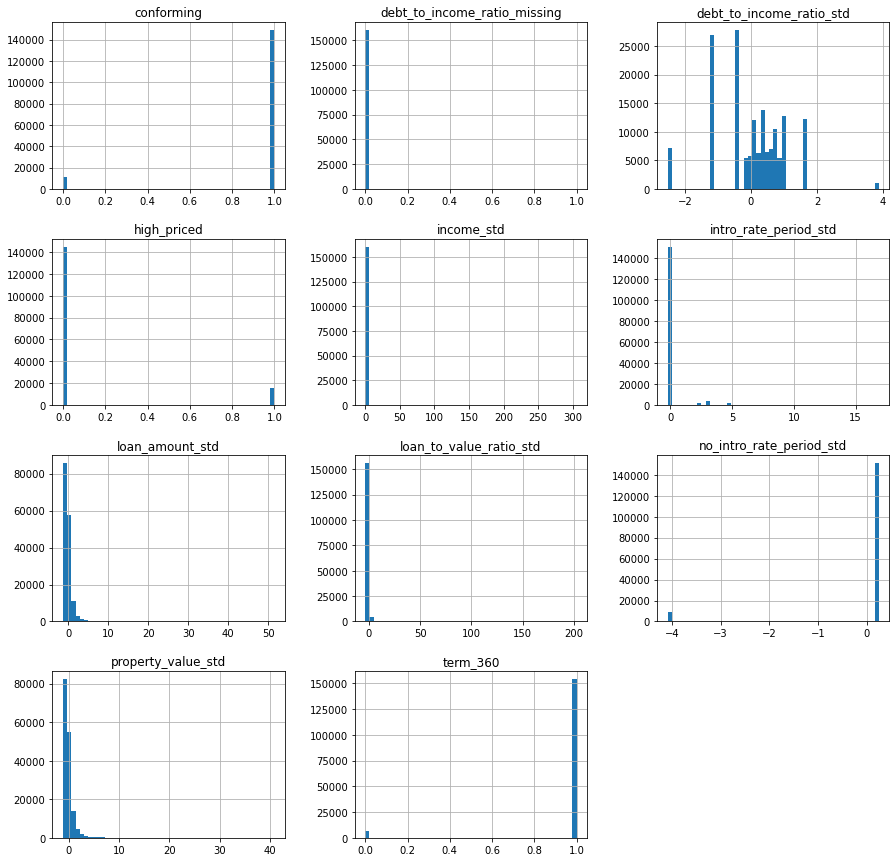

In [7]:
histogram = data[x + [y]].hist(bins=50, figsize=(15, 15))

#### Correlations

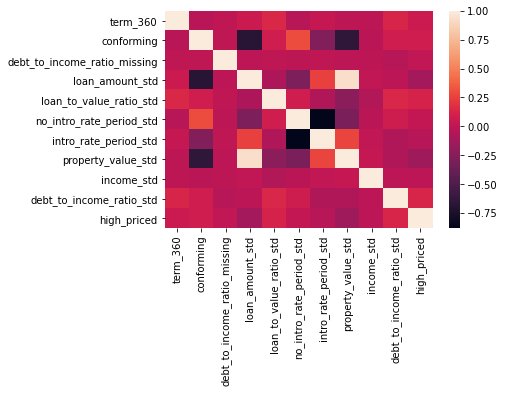

In [8]:
corr = data[x + [y]].corr()
correlationplot = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

#### Box Plots

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\boxplot.py:364: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020A580E98B0>,
      dtype=object)

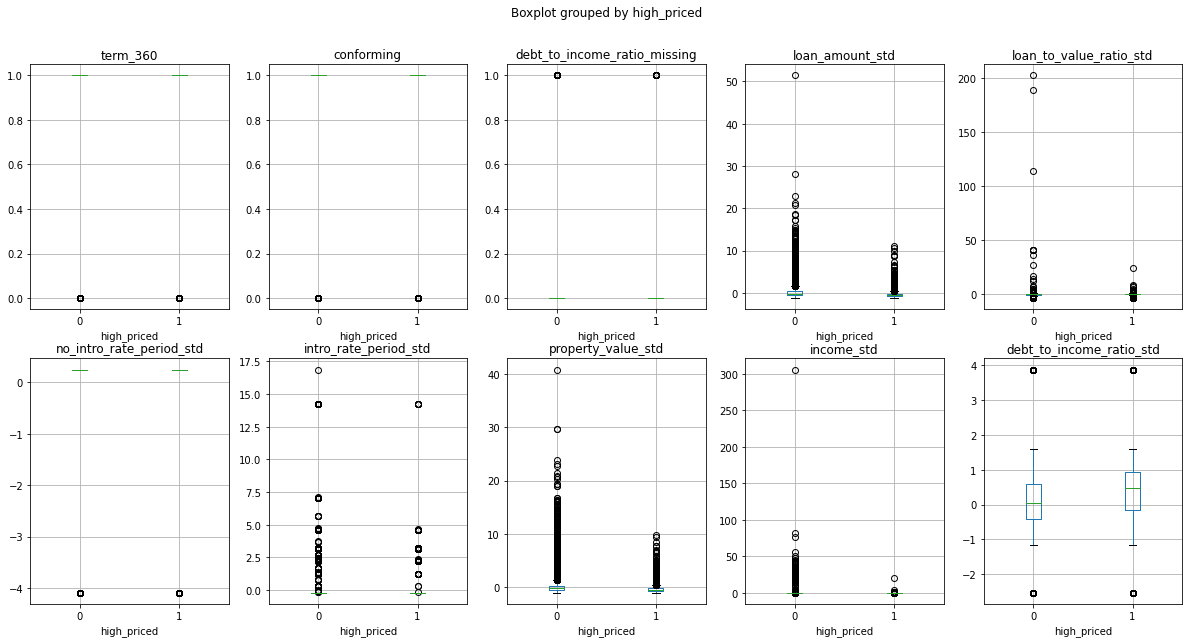

In [9]:
fig, axs = plt.subplots(2,5,figsize=(20,10),sharey=False)
data.boxplot(x,y,axs)

## 3.) Train Interpretable Models

### 3a.) Explainable Boosting Machine (EBM)

#### Split Data Into Training And Validation Partitions

In [10]:
split_ratio = 0.7 # 70%/30% train/test split

# split execution
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# split summary
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# conversion
train_X = train[x]
valid_X = valid[x]
train_y = train[y]
valid_y = train[y]

Train data rows = 112272, columns = 23
Validation data rows = 48066, columns = 23


#### Train EBM

In [11]:
ebm = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm.fit(train_X, train_y)  

ExplainableBoostingClassifier(feature_names=['term_360', 'conforming',
                                             'debt_to_income_ratio_missing',
                                             'loan_amount_std',
                                             'loan_to_value_ratio_std',
                                             'no_intro_rate_period_std',
                                             'intro_rate_period_std',
                                             'property_value_std', 'income_std',
                                             'debt_to_income_ratio_std',
                                             'loan_to_value_ratio_std x '
                                             'no_intro_rate_period_std',
                                             'loan_to_value_ratio_std x '
                                             'intro_rate_per...
                                             'loan_amount_std x '
                                             'intro_rate_period_std'

#### EBM Feature Plots

In [12]:
global_ebm = ebm.explain_global(name='EBM')
show(global_ebm)

<!-- http://127.0.0.1:7658/2243468770848/ -->

#### Static Values for Explanatory Content Rendered With Static Plots

In [13]:
# local timer starts 
ebm_tic = time.time()

ebm_contribs = ebm.explain_local(valid_X)
names = ebm_contribs._internal_obj['specific'][0]['names']
ebm_contribs_df = pd.DataFrame(columns=names)

for i in range(0, valid_X.shape[0]):
    row_df = pd.DataFrame(np.array(ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 20), columns=names)
    ebm_contribs_df = ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# local timer ends
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

EBM contributions collected in 88.59 s.


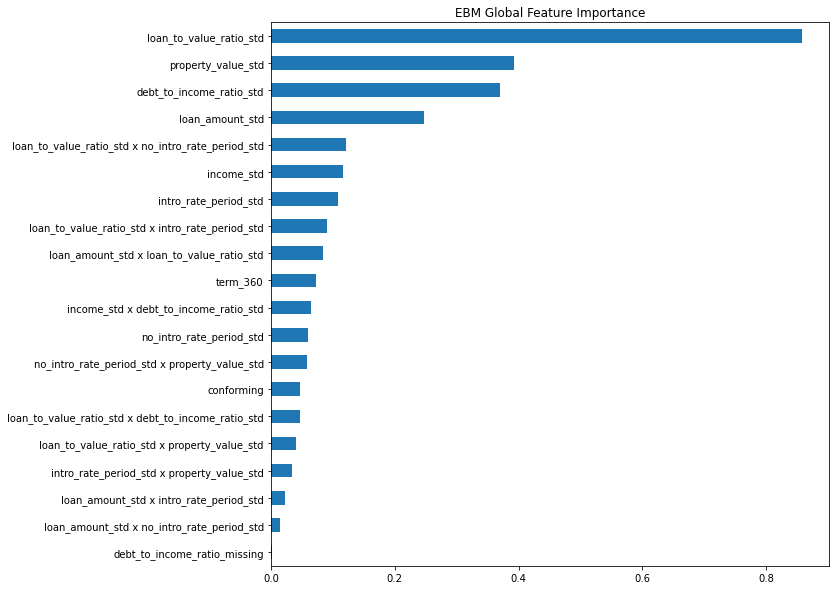

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
_ = np.abs(ebm_contribs_df).mean().sort_values().plot(kind='barh', ax=ax, title='EBM Global Feature Importance')

#### Utility Function To Manually Plot Partial Independence

In [15]:
def par_dep(x_name, valid, model, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    pd.options.mode.chained_assignment = None

    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    col_cache = valid.loc[:, x_name].copy(deep=True)

    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    valid.loc[:, x_name] = col_cache

    temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

#### Partial Dependence Calculation

In [16]:
# local timer starts 
pd_tic = time.time()

pd_dict = {}

for name in x:
    
    print('Calculating partial dependence for %s ...' % name)
    pd_dict[name] = par_dep(name, valid_X, ebm)
    
print('Done.')

# local timer ends
ebm_toc = time.time() - ebm_tic
print('Partial dependence calculated in %.2f s.' % (ebm_toc))

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.
Partial dependence calculated in 140.87 s.


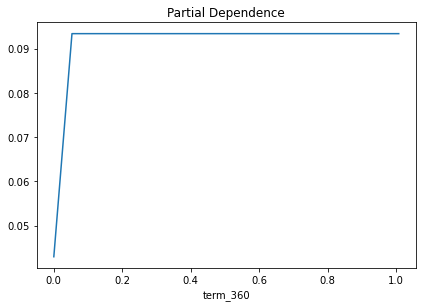

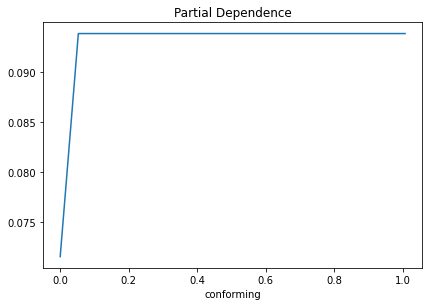

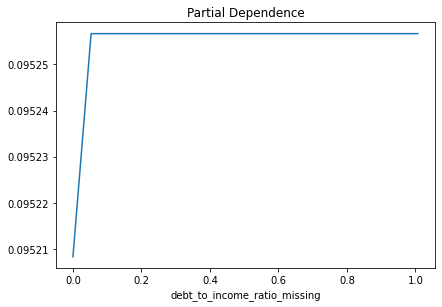

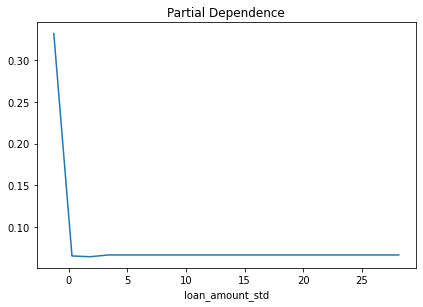

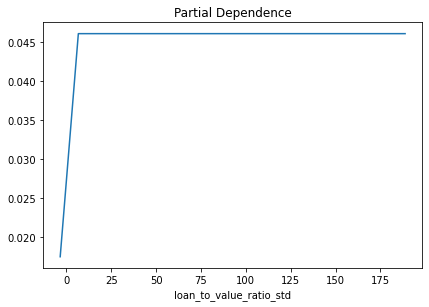

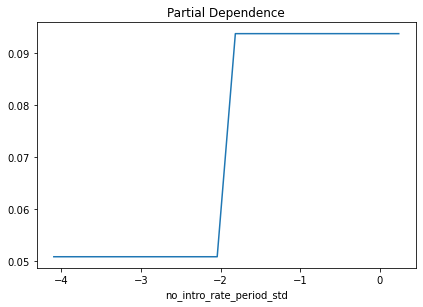

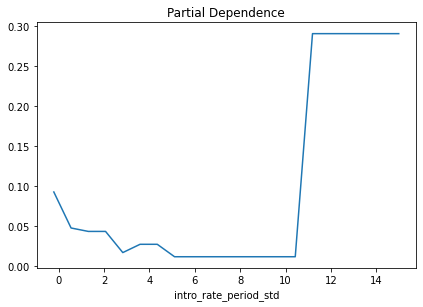

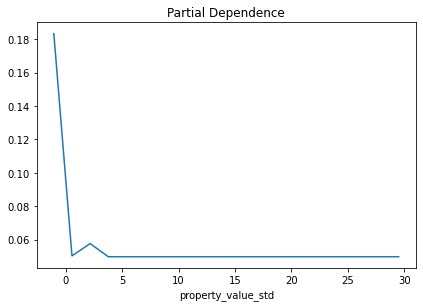

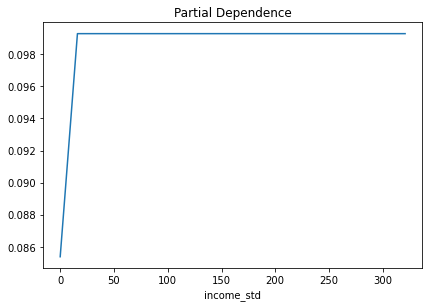

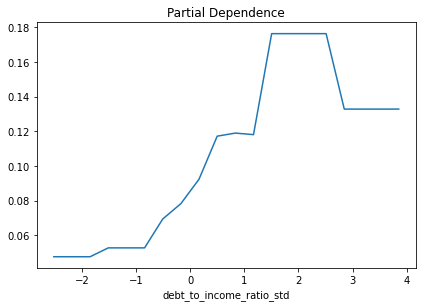

In [17]:
# calculate partial dependence by looping through names
for name in x:
    
    # init plot
    fig, ax = plt.subplots()
    plt.tight_layout()

    # partial dependence plots from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='partial_dependence', ax=ax, title='Partial Dependence',
                      legend=False)
    ax.set_xlabel(name)

#### Utility Function For Random Grid Search 

In [18]:
def ebm_grid(train, valid, x, y, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """
    
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    np.random.seed(SEED) 
    
    selected_experiments = np.random.choice(len(experiments), n_models)

    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    best_candidate = None
    best_score = 0

    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x], train[y]) 
        
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x], valid[y])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

#### Fit EBM With Random Grid Search

In [19]:
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# local timer starts
ebm_tic = time.time()

best_ebm = ebm_grid(train, valid, x, y, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# local timer ends
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 54321, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}
Grid search new best score discovered at iteration 1/10: 0.8200.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 54321, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 54321, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'm

#### Basic AUC Assessment

In [20]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x], valid[y])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8225.


#### Submission File

In [21]:
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x])[:, 1], columns=['phat'])
best_ebm_submit.to_csv('group_6_best_ebm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

#### End Global Timer

In [22]:
big_toc = time.time() - big_tic
print('All tasks completed in %.2f s.' % (big_toc))

All tasks completed in 730.64 s.


### 3b.) Monotonic Gradient Boosting Machine (MGBM)

#### Utility Function For Random Grid Search 

In [23]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    np.random.seed(SEED) 
    
    selected_experiments = np.random.choice(len(experiments), n_models)

    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    best_candidate = None
    best_score = 0

    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

#### Fitting Monotonic XGBoost With Random Grid Search

In [24]:
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

mono_constraints = tuple([int(i) for i in np.sign(train[x + [y]].corr()[y].values[:-1])])

# local timer starts 
mxgb_tic = time.time()

dtrain = xgb.DMatrix(train[x], train[y])
dvalid = xgb.DMatrix(valid[x], valid[y])

best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# local timer ends 
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 54321, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/50: 0.7927.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 54321, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.3, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 54321, 'colsample_bytree'

---------- ----------
Grid search run 21/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 54321, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 22/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 54321, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 23/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 54321, '

---------- ----------
Grid search run 41/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 54321, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 42/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 54321, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 43/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 5432

#### Basic AUC Assessment

In [25]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7927.


#### Submission File

In [26]:
dtest = xgb.DMatrix(test[x])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
best_mxgb_submit.to_csv('group_6_best_mxgb_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

